In [1]:
import os
import pandas as pd

In [2]:
from stellargraph import StellarGraph
from stellargraph.mapper import (CorruptedGenerator, FullBatchNodeGenerator)
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphInfomax, GCN
from stellargraph.utils import plot_history
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.preprocessing import normalize

2022-11-17 19:39:26.263801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
src_dir = './processed_data/'

nodes_DBLP_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_DBLP.csv'),
    index_col = 0
)


fpath_list = ['nodes_DBLP_edges_withRelations.csv']
df_edges = None
for fpath in fpath_list:
    _df = pd.read_csv( os.path.join(src_dir,fpath), index_col = None )
    if df_edges is None : df_edges = _df
    else:
        df_edges = df_edges.append(_df,ignore_index= True)

In [19]:
graph_obj = StellarGraph({
    "DBLP": nodes_DBLP_df
},
    df_edges, edge_type_column="orientation"
)

In [20]:
print(graph_obj.info())

StellarGraph: Undirected multigraph
 Nodes: 8760, Edges: 51228

 Node types:
  DBLP: [8760]
    Features: float32 vector, length 2470
    Edge types: DBLP->Paper-Author->DBLP, DBLP->Paper-Conference->DBLP, DBLP->Paper-Term->DBLP

 Edge types:
    DBLP->Paper-Term->DBLP: [30682]
        Weights: all 1 (default)
        Features: none
    DBLP->Paper-Author->DBLP: [15868]
        Weights: all 1 (default)
        Features: none
    DBLP->Paper-Conference->DBLP: [4678]
        Weights: all 1 (default)
        Features: none


In [6]:
import keras
import time
class TimeHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [7]:
model_use_data_DIR = 'model_use_data'
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
model_use_data_DIR = os.path.join(model_use_data_DIR,'DBLP')
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)


model_save_path = 'model_save_dir'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
model_save_path = os.path.join(model_save_path,'DBLP')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    

model_save_ComputationTimePerEpoch = 'model_save_ComputationTime'
if not os.path.exists(model_save_ComputationTimePerEpoch):
    os.mkdir(model_save_ComputationTimePerEpoch)
model_save_ComputationTimePerEpoch = os.path.join(model_save_ComputationTimePerEpoch,'DBLP')
if not os.path.exists(model_save_ComputationTimePerEpoch):
    os.mkdir(model_save_ComputationTimePerEpoch)
    

emb_fpath_GAT = os.path.join(model_use_data_DIR, 'embeddings_GAT.npy')
emb_fpath_GCN = os.path.join(model_use_data_DIR, 'embeddings_GCN.npy')
emb_fpath_RGCN = os.path.join(model_use_data_DIR, 'embeddings_RGCN.npy')
emb_fpath_HINSAGE = os.path.join(model_use_data_DIR, 'embeddings_HINSAGE.npy')

In [8]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
time_callback = TimeHistory()
def run_deep_graph_infomax(base_model, generator, epochs, reorder=lambda sequence, subjects: subjects):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(graph_obj.nodes(node_type='DBLP'))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)   
    history = model.fit(gen, epochs=epochs, verbose=2, callbacks=[time_callback])
    plot_history(history)
    
    return emb_model #, x_emb_in, x_emb_out, all_embeddings

Using GCN (local pooling) filters...


/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
1/1 - 1s - loss: 0.2633 - 535ms/epoch - 535ms/step
Epoch 2/100
1/1 - 1s - loss: 0.2550 - 553ms/epoch - 553ms/step
Epoch 3/100
1/1 - 1s - loss: 0.2648 - 547ms/epoch - 547ms/step
Epoch 4/100
1/1 - 1s - loss: 0.2553 - 538ms/epoch - 538ms/step
Epoch 5/100
1/1 - 1s - loss: 0.2532 - 540ms/epoch - 540ms/step
Epoch 6/100
1/1 - 1s - loss: 0.2479 - 544ms/epoch - 544ms/step
Epoch 7/100
1/1 - 1s - loss: 0.2502 - 549ms/epoch - 549ms/step
Epoch 8/100
1/1 - 1s - loss: 0.2507 - 550ms/epoch - 550ms/step
Epoch 9/100
1/1 - 1s - loss: 0.2527 - 881ms/epoch - 881ms/step
Epoch 10/100
1/1 - 1s - loss: 0.2497 - 563ms/epoch - 563ms/step
Epoch 11/100
1/1 - 1s - loss: 0.2435 - 566ms/epoch - 566ms/step
Epoch 12/100
1/1 - 1s - loss: 0.2422 - 554ms/epoch - 554ms/step
Epoch 13/100
1/1 - 1s - loss: 0.2396 - 545ms/epoch - 545ms/step
Epoch 14/100
1/1 - 1s - loss: 0.2417 - 549ms/epoch - 549ms/step
Epoch 15/100
1/1 - 1s - loss: 0.2335 - 552ms/epoch - 552ms/step
Epoch 16/100
1/1 - 1s - loss: 0.2437 - 535ms/epoc

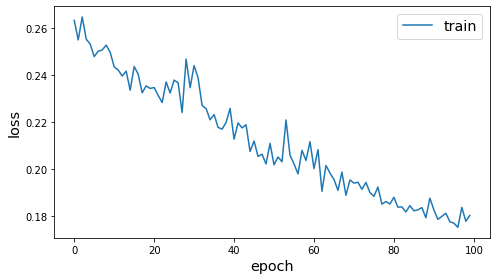

In [9]:
#GCN
fullbatch_generator_gcn = FullBatchNodeGenerator(graph_obj, sparse=True)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator_gcn)
gcn = run_deep_graph_infomax(gcn_model, fullbatch_generator_gcn, epochs=100)

In [10]:
#GCN OUTPUT
emb_gcn_model_output = gcn

In [21]:
fullbatch_generator_gcn = FullBatchNodeGenerator(graph_obj, sparse=True)

Using GCN (local pooling) filters...


In [24]:
fullbatch_generator_gcn.flow([6754])

In [25]:
emb_gcn_model_output.predict(fullbatch_generator_gcn.flow([6754]))

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/graph_convolution/SparseTensorDenseMatMul/SparseTensorDenseMatMul' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 563, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1844, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/2b/x_m3n03152x9tj_8wc0mpq7w0000gn/T/ipykernel_15699/2444809389.py", line 1, in <module>
      emb_gcn_model_output.predict(fullbatch_generator_gcn.flow([6754]))
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/stellargraph/layer/gcn.py", line 195, in call
      if K.is_sparse(A):
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/stellargraph/layer/gcn.py", line 209, in call
      h_graph = K.dot(A, features_sq)
    File "/Users/sagarkaw/Library/Python/3.8/lib/python/site-packages/keras/backend.py", line 2221, in dot
      out = tf.sparse.sparse_dense_matmul(x, y)
Node: 'model_1/graph_convolution/SparseTensorDenseMatMul/SparseTensorDenseMatMul'
Cannot multiply A and B because inner dimension does not match: 8758 vs. 8760.  Did you forget a transpose?  Dimensions of A: [8758, 8758).  Dimensions of B: [8760,2470]
	 [[{{node model_1/graph_convolution/SparseTensorDenseMatMul/SparseTensorDenseMatMul}}]] [Op:__inference_predict_function_2883]

In [ ]:
#GCN EMBEDDING GENERATION
node_embeddings_gcn = []
for i in range(len(graph_obj.nodes())):
    vec = emb_gcn_model_output.predict(fullbatch_generator_gcn.flow([i]))
    node_embeddings_gcn.append(vec[0])
node_embeddings_GCN = np.array(node_embeddings_gcn)
np.save(emb_fpath_GCN, node_embeddings_GCN)

In [ ]:
#GCN EPOCHS TIME
times = time_callback.times
cumulative_times = times
for i in range(len(cumulative_times)):
    if(i>0):
        cumulative_times[i] = cumulative_times[i]+cumulative_times[i-1]
time_per_epoch = []
for i in range(1,101):
    time_per_epoch.append((i,cumulative_times[i-1]))
df_time_per_epoch = pd.DataFrame(time_per_epoch)
df_time_per_epoch.to_csv(model_save_ComputationTimePerEpoch + "/GCN_time_per_epoch.csv")

In [ ]:
node_embeddings_normalized_GCN = normalize(node_embeddings_GCN, axis=1, norm='l2')

In [ ]:
entity_id_mapping = pd.read_csv(src_dir + 'entity_id_mapping.csv')

In [ ]:
#GCN SAVING USER EMBEDDINGS AND SKILL EMBEDDINGS
embedding_dict_gcn = {'user': {}, 'skill': {}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict_gcn['user'].update({row['entity_id']: node_embeddings_normalized_GCN[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict_gcn['skill'].update({row['entity_id']: node_embeddings_normalized_GCN[row['serial_id']]}) 
pickle.dump(embedding_dict_gcn, open(model_save_path + '/embedding_dict_gcn.pkl', 'wb'))

In [ ]:
#GCN SAVING USER EMBEDDINGS, SKILL EMBEDDINGS AND CONFERENCE EMBEDDINGS
embedding_dict_USC_gcn = {'user': {}, 'skill': {}, 'conf':{}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict_USC_gcn['user'].update({row['entity_id']: node_embeddings_normalized_GCN[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict_USC_gcn['skill'].update({row['entity_id']: node_embeddings_normalized_GCN[row['serial_id']]})
    elif row['domain'] == 'conf':
        embedding_dict_USC_gcn['conf'].update({row['entity_id']: node_embeddings_normalized_GCN[row['serial_id']]})
        
pickle.dump(embedding_dict_USC_gcn, open(model_save_path + '/embedding_dict_USC_gcn.pkl', 'wb'))